# Determine DEGs in Deseq2 Data

## <br> 1. Import Required Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import gridspec


## <br> 2. Import Deseq2 Data

In [2]:
# Load DESeq2 master table with MGI annotations and format the 'Dose' column
Deseq2_Directory = './Results/03d_MASTER_Deseq2_Concatonated/RDDR_Deseq2_Master_Wald_with_MGI.txt'

Deseq2_Master = pd.read_csv(Deseq2_Directory, 
                            delimiter = '\t',
                            index_col=0)

Deseq2_Master['Dose'] = Deseq2_Master['Dose'].apply(lambda x: '{:.2g}'.format(x)).astype('category')

# Specify the desired order for the Dose levels
dose_order = ['0.01', '0.03', '0.1', '0.3', '1', '3', '10', '30']

# Convert 'Dose' column to a categorical type with the specified order
Deseq2_Master['Dose'] = pd.Categorical(Deseq2_Master['Dose'], categories=dose_order, ordered=True)

Deseq2_Master

,Gene,MGI_Symbol,Celltype,Dose,Type,pDRE,AHR,baseMean,Chr,Start,End,Strand,NR_Annotation,log2FoldChange,Fold-Change,lfcSE,stat,pvalue,padj
0,lnc31752,Malat1,B Cells,0.01,lncRNA,0,2,5632.003911,chr19,5842642,5852983,-,lnc31752_Mascrna#Malat1,0.060929,1.043137,0.161392,0.377519,0.705788,1.000000
1,lnc4822,.,B Cells,0.01,lncRNA,0,1,3146.387654,chr6,3181101,3202501,+,lnc4822,-0.368362,0.774662,0.385441,-0.955691,0.339228,1.000000
2,Foxp1,9130401L11Rik,B Cells,0.01,NM,13,19,941.129495,chr6,98902302,99161922,-,NaN,-0.079404,0.946448,0.359311,-0.220991,0.825099,1.000000
3,Foxp1,6030492E11Rik,B Cells,0.01,NM,13,19,941.129495,chr6,98902302,99161922,-,NaN,-0.079404,0.946448,0.359311,-0.220991,0.825099,1.000000
4,Foxp1,Gm38865,B Cells,0.01,NM,13,19,941.129495,chr6,98902302,99161922,-,NaN,-0.079404,0.946448,0.359311,-0.220991,0.825099,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1443131,lnc1440,.,pDCs,30,lncRNA,0,0,2.409755,chr2,69058214,69067863,-,lnc1440,-4.176886,0.055288,1.226191,-3.406392,0.000658,0.004671
1443132,lnc1686,Gm34484,pDCs,30,lncRNA,0,1,0.496732,chr2,124519234,124553367,-,lnc1686,3.818752,14.111033,4.487664,0.850944,0.394800,0.614526
1443133,lnc2311,Gm40040,pDCs,30,lncRNA,3,3,2.592510,chr3,41395983,41447665,-,lnc2311_Platr4Gm40040,-4.979600,0.031695,1.133711,-4.392302,0.000011,0.000141
1443134,lnc2311,Platr4,pDCs,30,lncRNA,3,3,2.592510,chr3,41395983,41447665,-,lnc2311_Platr4Gm40040,-4.979600,0.031695,1.133711,-4.392302,0.000011,0.000141


### Determine total number of genes that were identified in our dataset (accross all cell types). 

In [3]:
unique_gene_count = Deseq2_Master['Gene'].nunique()
unique_gene_count

28424

In [4]:
Deseq2_Master['Dose'].unique()

['0.01', '0.03', '0.1', '0.3', '1', '3', '10', '30']
Categories (8, object): ['0.01' < '0.03' < '0.1' < '0.3' < '1' < '3' < '10' < '30']

## <br> 3. Find Total Genes, DEGs, lncRNA DEGs, and Protein-Coding DEGs in Centrilobular Hepatocytes

FC >= 1.5 <br>
padj 0.05

In [5]:
# Define Celltype of Interest
COI = "Centrilobular Hepatocytes"
COI = COI.strip()

# define dose of interest
doi = 30.00

#define Log2FC threshold and padj-value
FC = 1.5
padj = 0.05

In [6]:
######################################################
# Determine Total Genes in Celltype of Interest
######################################################
All_Genes = Deseq2_Master[Deseq2_Master['Celltype'] == COI]
All_Genes_List = All_Genes[['Gene']].drop_duplicates(keep='first').copy()


All_DEGs = All_Genes[((All_Genes['Fold-Change'] >= FC) | 
                      (All_Genes['Fold-Change'] <= 1/FC)) &
                      (All_Genes['padj'] <= padj)]
All_DEGs_List = All_DEGs[['Gene']].drop_duplicates(keep='first').copy()


######################################################
# Determine DEGs transcript types for Celltype of Interest
######################################################
lncRNA_DEGs = All_DEGs[(All_DEGs['Type'] == 'lncRNA') |
                       (All_DEGs['Type']== 'antisense') |
                       (All_DEGs['Type']== 'lincRNA') |
                       (All_DEGs['Type']== 'NR') |
                       (All_DEGs['Type']== 'lncOfInterest')]
lncRNA_DEGs_List = lncRNA_DEGs[['Gene']].drop_duplicates(keep='first').copy()

protein_DEGs = All_DEGs[(All_DEGs['Type'] == 'NM') |
                        (All_DEGs['Type'] == 'NM#NR')|
                        (All_DEGs['Type'] == 'protein_coding')]
protein_DEGs_List = protein_DEGs[['Gene']].drop_duplicates(keep='first').copy()

######################################################
# Determine DEGs transcript types for with AHR Binding
######################################################
lncRNA_DEGs_AHR = lncRNA_DEGs[(lncRNA_DEGs['AHR'] != 0)]
lncRNA_DEGs_AHR_List = lncRNA_DEGs_AHR[['Gene']].drop_duplicates(keep='first').copy()

protein_DEGs_AHR = protein_DEGs[(protein_DEGs['AHR'] != 0)]
protein_DEGs_AHR_List = protein_DEGs_AHR[['Gene']].drop_duplicates(keep='first').copy()

######################################################
# Determine DEGs transcript types for with DRE
######################################################
lncRNA_DEGs_DRE = lncRNA_DEGs[(lncRNA_DEGs['pDRE'] != 0)]
lncRNA_DEGs_DRE_List = lncRNA_DEGs_DRE[['Gene']].drop_duplicates(keep='first').copy()

protein_DEGs_DRE = protein_DEGs[(protein_DEGs['pDRE'] != 0)]
protein_DEGs_DRE_List = protein_DEGs_DRE[['Gene']].drop_duplicates(keep='first').copy()


In [7]:
######################################################
# Print Out Counts
######################################################
print("##################")
print("### " + COI)
print("##################")
print("--------------------------------------------------------")
print("--------------------------------------------------------")
print()
print("All Genes:", len(All_Genes_List))
print()
print("All DEGs:", len(All_DEGs_List))
print()
print("--------------------------------------------------------")
print("--------------------------------------------------------")
print()
print("lncRNA DEGs:", len(lncRNA_DEGs_List))
print()
print("lncRNA DEGs with AHR:", len(lncRNA_DEGs_AHR_List))
print()
print("lncRNA DEGs with DRE:", len(lncRNA_DEGs_DRE_List))
print()
print("--------------------------------------------------------")
print("--------------------------------------------------------")
print()
print("protein-coding DEGs:", len(protein_DEGs_List))
print()
print("protein-coding DEGs with AHR:", len(protein_DEGs_AHR_List))
print()
print("protein-coding DEGs with DRE:", len(protein_DEGs_DRE_List))
print()
print("--------------------------------------------------------")
print("--------------------------------------------------------")

##################
### Centrilobular Hepatocytes
##################
--------------------------------------------------------
--------------------------------------------------------

All Genes: 21908

All DEGs: 8840

--------------------------------------------------------
--------------------------------------------------------

lncRNA DEGs: 3463

lncRNA DEGs with AHR: 1652

lncRNA DEGs with DRE: 1211

--------------------------------------------------------
--------------------------------------------------------

protein-coding DEGs: 5372

protein-coding DEGs with AHR: 3532

protein-coding DEGs with DRE: 3385

--------------------------------------------------------
--------------------------------------------------------


## <br> 4. K-Means Clustering of all Hepatocyte lncRNA DEGs 

#### Only plotting data from 
1. Hepatocytes
2. Genes that were significant at any timepoint
3. Only lncRNAs

In [8]:
# Filter DEGs from lncRNAs in the specified cell type
Data_of_Interest = Deseq2_Master[(Deseq2_Master['Celltype'] == COI) & 
                                (Deseq2_Master['Type'] == 'lncRNA') |
                       (Deseq2_Master['Type']== 'antisense') |
                       (Deseq2_Master['Type']== 'lincRNA') |
                       (Deseq2_Master['Type']== 'NR') |
                       (Deseq2_Master['Type']== 'lncOfInterest')]

# Further filter DEGs based on fold change and adjusted p-value thresholds
Genes_to_Keep = Data_of_Interest[((Data_of_Interest['Fold-Change'] >= FC) | 
                                  (Data_of_Interest['Fold-Change'] <= 1/FC)) &
                                  (Data_of_Interest['padj'] <= padj)]

# Extract unique genes to keep
Genes_to_Keep_List = Genes_to_Keep[['Gene']].drop_duplicates(keep='first')

# Extract relevant columns for further analysis
Data_Filtered = Data_of_Interest[['Gene', 'Dose', 'log2FoldChange']].drop_duplicates(subset=['Gene', 'Dose'], keep='first')

# Pivot the DataFrame to arrange log2FoldChange values by Gene and Time
pivot_df = Data_Filtered.pivot(index='Gene', columns='Dose', values='log2FoldChange')

# Reset the index if needed
pivot_df.reset_index(inplace=True)

# Merge DEGs with log2FoldChange values
merged_df = pd.merge(Genes_to_Keep_List, pivot_df, on='Gene', how='left')

# Set 'Gene' column as index
merged_df.set_index('Gene', inplace=True)

# Convert the DataFrame to a NumPy array for clustering
pivot_array = merged_df.values
merged_df

,0.01,0.03,0.1,0.3,1,3,10,30
Gene,,,,,,,,
Serpina4-ps1,1.311211,-0.454264,1.081377,1.427112,0.296727,-0.859760,-7.656689,-9.476784
Mir6236,-0.540797,-1.047239,-0.226820,-1.164970,-0.050844,0.091406,-1.178689,-1.741614
AY036118,0.425293,0.066830,0.730922,0.782583,0.526478,0.877770,0.786246,0.911929
Cyp2d13,0.477872,-0.168357,-0.127108,-0.886468,-1.132307,-1.336535,-1.655225,-6.788632
AU020206,0.046038,-0.570375,0.034342,0.751667,0.385300,0.654695,0.168810,2.224952
...,...,...,...,...,...,...,...,...
Gm14211,0.031557,0.491312,-1.425797,-2.612255,0.102525,0.453634,0.728572,0.917517
Gm40621,2.228300,2.608998,2.207116,2.551920,2.564724,2.750398,2.739649,3.461361
Gm39323,1.212802,1.195655,0.657473,1.937451,1.461016,0.779877,-0.147807,1.761128


## Define and Perform K-Means Clustering


In [9]:
# Number of clusters
num_clusters = 5  # Adjust this number as needed

# Initialize KMeans
kmeans = KMeans(n_clusters=num_clusters, random_state=827)

numeric_data = pivot_array[:, 1:].astype(float)

# Fit KMeans to the data
kmeans.fit(numeric_data)

# Get cluster labels
cluster_labels = kmeans.labels_


In [10]:
# Convert column names to string
merged_df.columns = merged_df.columns.astype(str)

# Assign cluster labels to the DataFrame
merged_df['Cluster'] = kmeans.labels_

# Sort the DataFrame by cluster
merged_df_sorted = merged_df.sort_values(by='Cluster')

# Calculate the mean values for each time point within each cluster
cluster_means = merged_df.groupby('Cluster')[['0.01', '0.03', '0.1', '0.3', '1', '3', '10', '30']].mean()
cluster_means

# Select specific columns for selected_df
selected_columns = ['0.01', '0.03', '0.1', '0.3', '1', '3', '10', '30']
selected_df = merged_df_sorted[selected_columns]
selected_df

,0.01,0.03,0.1,0.3,1,3,10,30
Gene,,,,,,,,
lnc23943,0.754471,0.017618,0.241143,1.186945,-0.868572,0.565734,0.420056,2.351631
lnc5585,1.100448,0.880568,0.540962,0.750730,1.465143,-0.214636,0.893531,2.580478
lnc13740,-0.942097,-0.680471,0.020629,-0.217319,0.562084,-0.036531,-0.285922,1.263916
lnc13208,-0.018074,-0.058573,-0.204554,-0.213187,0.096724,-0.080294,-0.309504,0.888225
Gm26613,0.992687,-1.406678,0.614940,0.997305,-1.628284,-0.403687,0.742529,1.032076
...,...,...,...,...,...,...,...,...
lnc50392,0.353954,1.097329,0.777167,1.269075,1.390957,1.439281,2.437308,1.711517
lnc45806,1.102797,0.729678,1.625713,1.855280,1.023815,1.274050,1.852834,3.393870
lnc5731,-0.031181,0.068193,0.276184,1.646246,1.421799,1.671012,1.953753,1.479567


## 5. Plot k-means data

In [11]:
# Define 6 different colors
colors = ['red','orange', 'green', 'blue',  'purple']
custom_cmap = ListedColormap(colors)

# Define the blue, white, and red colormap
colors = ["#0000FF", "#FFFFFF", "#FF0000"]
blue_white_red = LinearSegmentedColormap.from_list("BlueWhiteRed", colors)

COI = COI.replace(' ', '_')

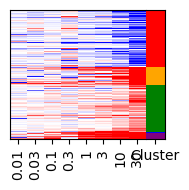

In [37]:
# Create the figure
fig = plt.figure(figsize=(2, 2))

# Create the outer GridSpec
outer = gridspec.GridSpec(1, 2, width_ratios=[7, 1], wspace=0.0)

# Create inner GridSpec for the first subplot (selected_df)
inner1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[0],width_ratios=[7], wspace=0)

# Create inner GridSpec for the second subplot (cluster_df)
inner2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[1], width_ratios=[1],wspace=0)

# Create the heatmap for selected_df
ax1 = fig.add_subplot(inner1[0])
sns.heatmap(selected_df, cmap=blue_white_red, 
            linewidths=0, linecolor='black', 
            vmin=-2, vmax=2, cbar=False, ax=ax1)
#ax1.set_xlabel('Dose')
ax1.set_xticks([])
ax1.set_xlabel('')
ax1.set_yticks([])
ax1.set_ylabel('')

for loc, spine in ax1.spines.items():
    if loc != 'right':
        spine.set_visible(True)
    else:
        spine.set_visible(False)

# Select specific columns for cluster_df
cluster_df = merged_df_sorted[['Cluster']]

# Create the heatmap for cluster_df
ax2 = fig.add_subplot(inner2[0])
sns.heatmap(cluster_df, cmap=custom_cmap, 
            linewidths=0, linecolor='black', 
            vmin=cluster_df.min().min(), vmax=cluster_df.max().max(), cbar=False, ax=ax2)
ax2.set_xticks([])
ax2.set_xlabel('')
ax2.set_yticks([])
ax2.set_ylabel('')

for loc, spine in ax2.spines.items():
    if loc != 'left':
        spine.set_visible(True)
    else:
        spine.set_visible(False)

# Adjust layout
plt.tight_layout()

# Export the plot as a PDF
plt.savefig('Figures/RDDR_' + COI + '_lncRNA_DEGs_Cluster_Heatmap.pdf')

# Show plot
plt.show()



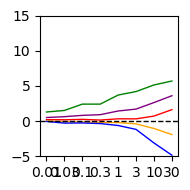

In [13]:
# Set the size of the figure and legend font size
plt.figure(figsize=(2, 2))

# Iterate over each cluster
for i, cluster in enumerate(cluster_means.index):
    # Get the mean values for the current cluster
    cluster_data = cluster_means.loc[cluster]
    
    # Plot a line graph for the current cluster with the custom color
    plt.plot(cluster_data.index.astype(str), cluster_data.values,
             label=f'Cluster {cluster}', color=custom_cmap(i), linewidth=1.0)
    
# Add labels and title
#plt.xlabel('Dose')
#plt.ylabel('Average Log2FC')
#plt.title('Average Values for Each Time Point by Cluster')
#plt.legend()
plt.grid(False)  # Remove gridlines
plt.yticks([-5,0,5,10,15])
plt.ylim(-5,15)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1.0)

# Adjust layout
plt.tight_layout()

# Export the plot as a PDF
plt.savefig('Figures/RDDR_' + COI + '_lncRNA_DEGs_Cluster_Means_Lineplot.pdf')

# Show the plot
plt.show()


# Protein Coding in Central Hepatocytes

In [14]:
# Define Celltype of Interest
COI = "Centrilobular Hepatocytes"
COI = COI.strip()

# define dose of interest
doi = 30.00

#define Log2FC threshold and padj-value
FC = 1.5
padj = 0.05

## <br> 4. K-Means Clustering of all Hepatocyte mRNAs DEGs 

#### Only plotting data from 
1. Hepatocytes
2. Genes that were significant at any timepoint
3. Only mRNAs

In [15]:
# Filter DEGs from lncRNAs in the specified cell type
Data_of_Interest = Deseq2_Master[(Deseq2_Master['Celltype'] == COI) & 
                                (Deseq2_Master['Type'] == 'NM') |
                       (Deseq2_Master['Type']== 'NM#NR') |
                       (Deseq2_Master['Type']== 'protein_coding')]

# Further filter DEGs based on fold change and adjusted p-value thresholds
Genes_to_Keep = Data_of_Interest[((Data_of_Interest['Fold-Change'] >= FC) | 
                                  (Data_of_Interest['Fold-Change'] <= 1/FC)) &
                                  (Data_of_Interest['padj'] <= padj)]

# Extract unique genes to keep
Genes_to_Keep_List = Genes_to_Keep[['Gene']].drop_duplicates(keep='first')

# Extract relevant columns for further analysis
Data_Filtered = Data_of_Interest[['Gene', 'Dose', 'log2FoldChange']].drop_duplicates(subset=['Gene', 'Dose'], keep='first')

# Pivot the DataFrame to arrange log2FoldChange values by Gene and Time
pivot_df = Data_Filtered.pivot(index='Gene', columns='Dose', values='log2FoldChange')

# Reset the index if needed
pivot_df.reset_index(inplace=True)

# Merge DEGs with log2FoldChange values
merged_df = pd.merge(Genes_to_Keep_List, pivot_df, on='Gene', how='left')

# Set 'Gene' column as index
merged_df.set_index('Gene', inplace=True)

# Convert the DataFrame to a NumPy array for clustering
pivot_array = merged_df.values
merged_df

,0.01,0.03,0.1,0.3,1,3,10,30
Gene,,,,,,,,
Nfe2l2,0.117062,0.134892,0.545112,-0.511897,0.995994,1.332624,2.097858,1.018352
Gsap,0.815428,1.444434,1.388448,0.830177,1.676596,2.232547,1.844441,1.074314
Mup3,1.027064,0.728813,0.292515,-1.146356,-0.262863,-0.188440,-2.830846,-9.324699
Grip1,1.772815,2.021825,0.255511,2.375275,1.746986,4.025688,4.796961,2.574607
Ptprd,0.069854,-0.211279,-0.099914,-0.125634,-0.406348,-0.197969,-0.325823,-3.105576
...,...,...,...,...,...,...,...,...
Brd2,0.638992,-0.295828,0.001031,-0.513487,-0.201421,-0.190786,-0.173914,-0.163397
Kcnip3,-0.116002,-0.003385,-0.158255,-0.173489,-0.083907,0.241717,0.554788,0.316820
Nbr1,0.132623,-0.031406,0.056393,0.337116,0.062400,0.149779,-0.197147,-0.265710


## Define and Perform K-Means Clustering


In [16]:
# Number of clusters
num_clusters = 5  # Adjust this number as needed

# Initialize KMeans
kmeans = KMeans(n_clusters=num_clusters, random_state=827)

numeric_data = pivot_array[:, 1:].astype(float)

# Fit KMeans to the data
kmeans.fit(numeric_data)

# Get cluster labels
cluster_labels = kmeans.labels_


In [17]:
# Convert column names to string
merged_df.columns = merged_df.columns.astype(str)

# Assign cluster labels to the DataFrame
merged_df['Cluster'] = kmeans.labels_

# Sort the DataFrame by cluster
merged_df_sorted = merged_df.sort_values(by='Cluster')

# Calculate the mean values for each time point within each cluster
cluster_means = merged_df.groupby('Cluster')[['0.01', '0.03', '0.1', '0.3', '1', '3', '10', '30']].mean()
cluster_means

# Select specific columns for selected_df
selected_columns = ['0.01', '0.03', '0.1', '0.3', '1', '3', '10', '30']
selected_df = merged_df_sorted[selected_columns]
selected_df

,0.01,0.03,0.1,0.3,1,3,10,30
Gene,,,,,,,,
Ank,0.066676,-0.101242,0.053788,0.043803,-0.173379,0.040392,-0.009258,-1.139099
Lrfn3,0.148175,-0.020293,-0.218453,-0.138723,0.107076,0.062084,-0.228049,-0.863627
Tmem37,0.078038,0.418531,0.586133,-1.188192,-0.170936,-0.216304,-1.423263,-2.557224
Myh10,0.065349,0.084249,-0.450861,-0.176918,-0.699557,-0.393802,-0.598946,-1.230655
Ces2e,0.178556,0.656580,0.528108,-0.698775,0.697973,0.845429,-0.161265,-0.974595
...,...,...,...,...,...,...,...,...
C130050O18Rik,1.653087,0.928773,1.140968,0.191636,1.326081,1.398460,0.942708,2.363226
Ddr1,-0.447432,0.685667,0.571917,-1.652657,-0.098756,-0.916171,3.068056,5.599436
Cd247,0.193881,0.410585,1.073941,0.110223,0.761116,1.576504,3.361620,4.370433


## 5. Plot k-means data

In [18]:
# Define 6 different colors
colors = ['red','orange', 'green', 'blue',  'purple']
custom_cmap = ListedColormap(colors)

# Define the blue, white, and red colormap
colors = ["#0000FF", "#FFFFFF", "#FF0000"]
blue_white_red = LinearSegmentedColormap.from_list("BlueWhiteRed", colors)

COI = COI.replace(' ', '_')

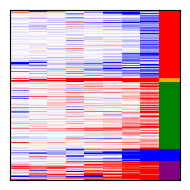

In [19]:
# Create the figure
fig = plt.figure(figsize=(2, 2))

# Create the outer GridSpec
outer = gridspec.GridSpec(1, 2, width_ratios=[7, 1], wspace=0.0)

# Create inner GridSpec for the first subplot (selected_df)
inner1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[0],width_ratios=[7], wspace=0)

# Create inner GridSpec for the second subplot (cluster_df)
inner2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[1], width_ratios=[1],wspace=0)

# Create the heatmap for selected_df
ax1 = fig.add_subplot(inner1[0])
sns.heatmap(selected_df, cmap=blue_white_red, 
            linewidths=0, linecolor='black', 
            vmin=-2, vmax=2, cbar=False, ax=ax1)
#ax1.set_xlabel('Dose')
ax1.set_xticks([])
ax1.set_xlabel('')
ax1.set_yticks([])
ax1.set_ylabel('')

for loc, spine in ax1.spines.items():
    if loc != 'right':
        spine.set_visible(True)
    else:
        spine.set_visible(False)

# Select specific columns for cluster_df
cluster_df = merged_df_sorted[['Cluster']]

# Create the heatmap for cluster_df
ax2 = fig.add_subplot(inner2[0])
sns.heatmap(cluster_df, cmap=custom_cmap, 
            linewidths=0, linecolor='black', 
            vmin=cluster_df.min().min(), vmax=cluster_df.max().max(), cbar=False, ax=ax2)
ax2.set_xticks([])
ax2.set_xlabel('')
ax2.set_yticks([])
ax2.set_ylabel('')

for loc, spine in ax2.spines.items():
    if loc != 'left':
        spine.set_visible(True)
    else:
        spine.set_visible(False)

# Adjust layout
plt.tight_layout()

# Export the plot as a PDF
plt.savefig('Figures/RDDR_' + COI + '_mRNA_DEGs_Cluster_Heatmap.pdf')

# Show plot
plt.show()



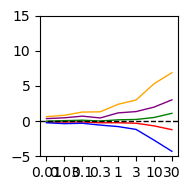

In [20]:
# Set the size of the figure and legend font size
plt.figure(figsize=(2, 2))

# Iterate over each cluster
for i, cluster in enumerate(cluster_means.index):
    # Get the mean values for the current cluster
    cluster_data = cluster_means.loc[cluster]
    
    # Plot a line graph for the current cluster with the custom color
    plt.plot(cluster_data.index.astype(str), cluster_data.values,
             label=f'Cluster {cluster}', color=custom_cmap(i), linewidth=1.0)
    
# Add labels and title
#plt.xlabel('Dose')
#plt.ylabel('Average Log2FC')
#plt.title('Average Values for Each Time Point by Cluster')
#plt.legend()
plt.grid(False)  # Remove gridlines
plt.yticks([-5,0,5,10,15])
plt.ylim(-5,15)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1.0)


# Adjust layout
plt.tight_layout()

# Export the plot as a PDF
plt.savefig('Figures/RDDR_' + COI + '_mRNA_DEGs_Cluster_Means_Lineplot.pdf')

# Show the plot
plt.show()


## <br> 3. Find Total Genes, DEGs, lncRNA DEGs, and Protein-Coding DEGs in Periportal Hepatocytes

FC >= 1.5 <br>
padj 0.05

In [21]:
# Define Celltype of Interest
COI = "Periportal Hepatocytes"
COI = COI.strip()

# define dose of interest
doi = 30.00

#define Log2FC threshold and padj-value
FC = 1.5
padj = 0.05

In [22]:
######################################################
# Determine Total Genes in Celltype of Interest
######################################################
All_Genes = Deseq2_Master[Deseq2_Master['Celltype'] == COI]
All_Genes_List = All_Genes[['Gene']].drop_duplicates(keep='first').copy()


All_DEGs = All_Genes[((All_Genes['Fold-Change'] >= FC) | 
                      (All_Genes['Fold-Change'] <= 1/FC)) &
                      (All_Genes['padj'] <= padj)]
All_DEGs_List = All_DEGs[['Gene']].drop_duplicates(keep='first').copy()


######################################################
# Determine DEGs transcript types for Celltype of Interest
######################################################
lncRNA_DEGs = All_DEGs[(All_DEGs['Type'] == 'lncRNA') |
                       (All_DEGs['Type']== 'antisense') |
                       (All_DEGs['Type']== 'lincRNA') |
                       (All_DEGs['Type']== 'NR') |
                       (All_DEGs['Type']== 'lncOfInterest')]
lncRNA_DEGs_List = lncRNA_DEGs[['Gene']].drop_duplicates(keep='first').copy()

protein_DEGs = All_DEGs[(All_DEGs['Type'] == 'NM') |
                        (All_DEGs['Type'] == 'NM#NR')|
                        (All_DEGs['Type'] == 'protein_coding')]
protein_DEGs_List = protein_DEGs[['Gene']].drop_duplicates(keep='first').copy()

######################################################
# Determine DEGs transcript types for with AHR Binding
######################################################
lncRNA_DEGs_AHR = lncRNA_DEGs[(lncRNA_DEGs['AHR'] != 0)]
lncRNA_DEGs_AHR_List = lncRNA_DEGs_AHR[['Gene']].drop_duplicates(keep='first').copy()

protein_DEGs_AHR = protein_DEGs[(protein_DEGs['AHR'] != 0)]
protein_DEGs_AHR_List = protein_DEGs_AHR[['Gene']].drop_duplicates(keep='first').copy()

######################################################
# Determine DEGs transcript types for with DRE
######################################################
lncRNA_DEGs_DRE = lncRNA_DEGs[(lncRNA_DEGs['pDRE'] != 0)]
lncRNA_DEGs_DRE_List = lncRNA_DEGs_DRE[['Gene']].drop_duplicates(keep='first').copy()

protein_DEGs_DRE = protein_DEGs[(protein_DEGs['pDRE'] != 0)]
protein_DEGs_DRE_List = protein_DEGs_DRE[['Gene']].drop_duplicates(keep='first').copy()


In [23]:
######################################################
# Print Out Counts
######################################################
print("##################")
print("### " + COI)
print("##################")
print("--------------------------------------------------------")
print("--------------------------------------------------------")
print()
print("All Genes:", len(All_Genes_List))
print()
print("All DEGs:", len(All_DEGs_List))
print()
print("--------------------------------------------------------")
print("--------------------------------------------------------")
print()
print("lncRNA DEGs:", len(lncRNA_DEGs_List))
print()
print("lncRNA DEGs with AHR:", len(lncRNA_DEGs_AHR_List))
print()
print("lncRNA DEGs with DRE:", len(lncRNA_DEGs_DRE_List))
print()
print("--------------------------------------------------------")
print("--------------------------------------------------------")
print()
print("protein-coding DEGs:", len(protein_DEGs_List))
print()
print("protein-coding DEGs with AHR:", len(protein_DEGs_AHR_List))
print()
print("protein-coding DEGs with DRE:", len(protein_DEGs_DRE_List))
print()
print("--------------------------------------------------------")
print("--------------------------------------------------------")

##################
### Periportal Hepatocytes
##################
--------------------------------------------------------
--------------------------------------------------------

All Genes: 25911

All DEGs: 9381

--------------------------------------------------------
--------------------------------------------------------

lncRNA DEGs: 3654

lncRNA DEGs with AHR: 1690

lncRNA DEGs with DRE: 1292

--------------------------------------------------------
--------------------------------------------------------

protein-coding DEGs: 5721

protein-coding DEGs with AHR: 3520

protein-coding DEGs with DRE: 3616

--------------------------------------------------------
--------------------------------------------------------


## <br> 4. K-Means Clustering of all Hepatocyte lncRNA DEGs 

#### Only plotting data from 
1. Hepatocytes
2. Genes that were significant at any timepoint
3. Only lncRNAs

In [24]:
# Filter DEGs from lncRNAs in the specified cell type
Data_of_Interest = Deseq2_Master[(Deseq2_Master['Celltype'] == COI) & 
                                (Deseq2_Master['Type'] == 'lncRNA') |
                       (Deseq2_Master['Type']== 'antisense') |
                       (Deseq2_Master['Type']== 'lincRNA') |
                       (Deseq2_Master['Type']== 'NR') |
                       (Deseq2_Master['Type']== 'lncOfInterest')]

# Further filter DEGs based on fold change and adjusted p-value thresholds
Genes_to_Keep = Data_of_Interest[((Data_of_Interest['Fold-Change'] >= FC) | 
                                  (Data_of_Interest['Fold-Change'] <= 1/FC)) &
                                  (Data_of_Interest['padj'] <= padj)]

# Extract unique genes to keep
Genes_to_Keep_List = Genes_to_Keep[['Gene']].drop_duplicates(keep='first')

# Extract relevant columns for further analysis
Data_Filtered = Data_of_Interest[['Gene', 'Dose', 'log2FoldChange']].drop_duplicates(subset=['Gene', 'Dose'], keep='first')

# Pivot the DataFrame to arrange log2FoldChange values by Gene and Time
pivot_df = Data_Filtered.pivot(index='Gene', columns='Dose', values='log2FoldChange')

# Reset the index if needed
pivot_df.reset_index(inplace=True)

# Merge DEGs with log2FoldChange values
merged_df = pd.merge(Genes_to_Keep_List, pivot_df, on='Gene', how='left')

# Set 'Gene' column as index
merged_df.set_index('Gene', inplace=True)

# Convert the DataFrame to a NumPy array for clustering
pivot_array = merged_df.values
merged_df

,0.01,0.03,0.1,0.3,1,3,10,30
Gene,,,,,,,,
Serpina4-ps1,1.311211,-0.454264,1.081377,1.427112,0.296727,-0.859760,-7.656689,-9.476784
Mir6236,-0.540797,-1.047239,-0.226820,-1.164970,-0.050844,0.091406,-1.178689,-1.741614
AY036118,0.425293,0.066830,0.730922,0.782583,0.526478,0.877770,0.786246,0.911929
Cyp2d13,0.477872,-0.168357,-0.127108,-0.886468,-1.132307,-1.336535,-1.655225,-6.788632
AU020206,0.046038,-0.570375,0.034342,0.751667,0.385300,0.654695,0.168810,2.224952
...,...,...,...,...,...,...,...,...
lnc24827,-4.211430,-0.455208,-0.378579,1.538569,0.172585,-0.044565,0.969210,3.122459
lnc32706,1.706106,1.544416,1.115740,1.001809,0.687933,-1.221739,1.756737,5.569056
Gm39323,1.212802,1.195655,0.657473,1.937451,1.461016,0.779877,-0.147807,1.761128


## Define and Perform K-Means Clustering


In [25]:
# Number of clusters
num_clusters = 5  # Adjust this number as needed

# Initialize KMeans
kmeans = KMeans(n_clusters=num_clusters, random_state=827)

numeric_data = pivot_array[:, 1:].astype(float)

# Fit KMeans to the data
kmeans.fit(numeric_data)

# Get cluster labels
cluster_labels = kmeans.labels_


In [26]:
# Convert column names to string
merged_df.columns = merged_df.columns.astype(str)

# Assign cluster labels to the DataFrame
merged_df['Cluster'] = kmeans.labels_

# Sort the DataFrame by cluster
merged_df_sorted = merged_df.sort_values(by='Cluster')

# Calculate the mean values for each time point within each cluster
cluster_means = merged_df.groupby('Cluster')[['0.01', '0.03', '0.1', '0.3', '1', '3', '10', '30']].mean()
cluster_means

# Select specific columns for selected_df
selected_columns = ['0.01', '0.03', '0.1', '0.3', '1', '3', '10', '30']
selected_df = merged_df_sorted[selected_columns]
selected_df

,0.01,0.03,0.1,0.3,1,3,10,30
Gene,,,,,,,,
lnc5517,0.208328,-0.844859,0.201223,0.943784,-0.073547,0.188218,0.615808,1.781217
lnc23825,1.085750,1.146919,0.271643,-0.191883,1.267754,1.349512,1.743724,0.436786
lnc40514,0.757456,0.586978,0.383858,0.109341,0.531334,0.687595,0.341061,1.527425
lnc29681,1.049238,0.696109,0.493653,0.398192,1.132358,0.729632,1.789868,1.987544
lnc41092,0.097457,1.130603,1.535450,2.398184,1.386359,0.977882,1.507574,2.232922
...,...,...,...,...,...,...,...,...
lnc12419,-0.540447,0.396677,1.063435,0.783501,2.906158,3.977141,5.004649,4.358812
lnc14879,1.695917,1.538373,1.270571,2.311475,1.649338,0.998270,1.556076,2.768860
lnc12403,-1.466241,-0.470700,-0.303043,0.415517,2.124714,2.650378,3.295580,3.185805


## 5. Plot k-means data

In [27]:
# Define 6 different colors
colors = ['red','orange', 'green', 'blue',  'purple']
custom_cmap = ListedColormap(colors)

# Define the blue, white, and red colormap
colors = ["#0000FF", "#FFFFFF", "#FF0000"]
blue_white_red = LinearSegmentedColormap.from_list("BlueWhiteRed", colors)

COI = COI.replace(' ', '_')

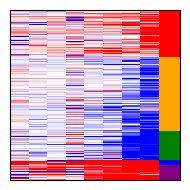

In [28]:
# Create the figure
fig = plt.figure(figsize=(2, 2))

# Create the outer GridSpec
outer = gridspec.GridSpec(1, 2, width_ratios=[7, 1], wspace=0.0)

# Create inner GridSpec for the first subplot (selected_df)
inner1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[0],width_ratios=[7], wspace=0)

# Create inner GridSpec for the second subplot (cluster_df)
inner2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[1], width_ratios=[1],wspace=0)

# Create the heatmap for selected_df
ax1 = fig.add_subplot(inner1[0])
sns.heatmap(selected_df, cmap=blue_white_red, 
            linewidths=0, linecolor='black', 
            vmin=-2, vmax=2, cbar=False, ax=ax1)
#ax1.set_xlabel('Dose')
ax1.set_xticks([])
ax1.set_xlabel('')
ax1.set_yticks([])
ax1.set_ylabel('')

for loc, spine in ax1.spines.items():
    if loc != 'right':
        spine.set_visible(True)
    else:
        spine.set_visible(False)

# Select specific columns for cluster_df
cluster_df = merged_df_sorted[['Cluster']]

# Create the heatmap for cluster_df
ax2 = fig.add_subplot(inner2[0])
sns.heatmap(cluster_df, cmap=custom_cmap, 
            linewidths=0, linecolor='black', 
            vmin=cluster_df.min().min(), vmax=cluster_df.max().max(), cbar=False, ax=ax2)
ax2.set_xticks([])
ax2.set_xlabel('')
ax2.set_yticks([])
ax2.set_ylabel('')

for loc, spine in ax2.spines.items():
    if loc != 'left':
        spine.set_visible(True)
    else:
        spine.set_visible(False)

# Adjust layout
plt.tight_layout()


# Export the plot as a PDF
plt.savefig('Figures/RDDR_' + COI + '_lncRNA_DEGs_Cluster_Heatmap.pdf')

# Show plot
plt.show()



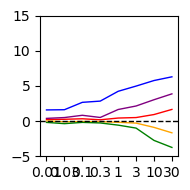

In [29]:
# Set the size of the figure and legend font size
plt.figure(figsize=(2, 2))

# Iterate over each cluster
for i, cluster in enumerate(cluster_means.index):
    # Get the mean values for the current cluster
    cluster_data = cluster_means.loc[cluster]
    
    # Plot a line graph for the current cluster with the custom color
    plt.plot(cluster_data.index.astype(str), cluster_data.values,
             label=f'Cluster {cluster}', color=custom_cmap(i), linewidth=1.0)
    
# Add labels and title
#plt.xlabel('Dose')
#plt.ylabel('Average Log2FC')
#plt.title('Average Values for Each Time Point by Cluster')
#plt.legend()
plt.grid(False)  # Remove gridlines
plt.yticks([-5,0,5,10,15])
plt.ylim(-5,15)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1.0)

# Adjust layout
plt.tight_layout()

# Export the plot as a PDF
plt.savefig('Figures/RDDR_' + COI + '_lncRNA_DEGs_Cluster_Means_Lineplot.pdf')

# Show the plot
plt.show()


# Protein Coding in Periportal Hepatocytes

In [30]:
# Define Celltype of Interest
COI = "Periportal Hepatocytes"
COI = COI.strip()

# define dose of interest
doi = 30.00

#define Log2FC threshold and padj-value
FC = 1.5
padj = 0.05

## <br> 4. K-Means Clustering of all Hepatocyte mRNAs DEGs 

#### Only plotting data from 
1. Hepatocytes
2. Genes that were significant at any timepoint
3. Only mRNAs

In [31]:
# Filter DEGs from lncRNAs in the specified cell type
Data_of_Interest = Deseq2_Master[(Deseq2_Master['Celltype'] == COI) & 
                                (Deseq2_Master['Type'] == 'NM') |
                       (Deseq2_Master['Type']== 'NM#NR') |
                       (Deseq2_Master['Type']== 'protein_coding')]

# Further filter DEGs based on fold change and adjusted p-value thresholds
Genes_to_Keep = Data_of_Interest[((Data_of_Interest['Fold-Change'] >= FC) | 
                                  (Data_of_Interest['Fold-Change'] <= 1/FC)) &
                                  (Data_of_Interest['padj'] <= padj)]

# Extract unique genes to keep
Genes_to_Keep_List = Genes_to_Keep[['Gene']].drop_duplicates(keep='first')

# Extract relevant columns for further analysis
Data_Filtered = Data_of_Interest[['Gene', 'Dose', 'log2FoldChange']].drop_duplicates(subset=['Gene', 'Dose'], keep='first')

# Pivot the DataFrame to arrange log2FoldChange values by Gene and Time
pivot_df = Data_Filtered.pivot(index='Gene', columns='Dose', values='log2FoldChange')

# Reset the index if needed
pivot_df.reset_index(inplace=True)

# Merge DEGs with log2FoldChange values
merged_df = pd.merge(Genes_to_Keep_List, pivot_df, on='Gene', how='left')

# Set 'Gene' column as index
merged_df.set_index('Gene', inplace=True)

# Convert the DataFrame to a NumPy array for clustering
pivot_array = merged_df.values
merged_df

,0.01,0.03,0.1,0.3,1,3,10,30
Gene,,,,,,,,
Nfe2l2,0.117062,0.134892,0.545112,-0.511897,0.995994,1.332624,2.097858,1.018352
Gsap,0.815428,1.444434,1.388448,0.830177,1.676596,2.232547,1.844441,1.074314
Mup3,1.027064,0.728813,0.292515,-1.146356,-0.262863,-0.188440,-2.830846,-9.324699
Grip1,1.772815,2.021825,0.255511,2.375275,1.746986,4.025688,4.796961,2.574607
Ptprd,0.069854,-0.211279,-0.099914,-0.125634,-0.406348,-0.197969,-0.325823,-3.105576
...,...,...,...,...,...,...,...,...
Brd2,0.638992,-0.295828,0.001031,-0.513487,-0.201421,-0.190786,-0.173914,-0.163397
Kcnip3,-0.116002,-0.003385,-0.158255,-0.173489,-0.083907,0.241717,0.554788,0.316820
Nbr1,0.132623,-0.031406,0.056393,0.337116,0.062400,0.149779,-0.197147,-0.265710


## Define and Perform K-Means Clustering


In [32]:
# Number of clusters
num_clusters = 5  # Adjust this number as needed

# Initialize KMeans
kmeans = KMeans(n_clusters=num_clusters, random_state=827)

numeric_data = pivot_array[:, 1:].astype(float)

# Fit KMeans to the data
kmeans.fit(numeric_data)

# Get cluster labels
cluster_labels = kmeans.labels_


In [33]:
# Convert column names to string
merged_df.columns = merged_df.columns.astype(str)

# Assign cluster labels to the DataFrame
merged_df['Cluster'] = kmeans.labels_

# Sort the DataFrame by cluster
merged_df_sorted = merged_df.sort_values(by='Cluster')

# Calculate the mean values for each time point within each cluster
cluster_means = merged_df.groupby('Cluster')[['0.01', '0.03', '0.1', '0.3', '1', '3', '10', '30']].mean()
cluster_means

# Select specific columns for selected_df
selected_columns = ['0.01', '0.03', '0.1', '0.3', '1', '3', '10', '30']
selected_df = merged_df_sorted[selected_columns]
selected_df

,0.01,0.03,0.1,0.3,1,3,10,30
Gene,,,,,,,,
Atrn,-0.118008,-0.352772,-0.147816,0.090133,-0.392028,-0.478164,-0.494622,-1.278459
Pink1,0.030668,-0.350713,0.015080,0.284845,-0.335875,-0.514490,-0.931245,-1.516916
Btrc,-0.112905,-0.022503,-0.096348,0.062702,0.150333,0.236857,0.151950,-0.726243
Nod1,-0.099718,-0.002363,0.015256,-0.399950,0.080115,0.187414,-0.821332,-0.025670
Zfp467,0.023093,0.343527,0.119631,-0.241308,-0.304841,-0.260759,-1.476805,-2.066969
...,...,...,...,...,...,...,...,...
Ndc80,0.061019,-0.597233,0.599699,1.105930,0.826722,-0.424924,3.115566,6.445982
Vxn,0.400014,-0.310550,0.401395,0.686534,1.664721,1.375299,3.828582,4.907655
Cnksr1,1.122047,1.763754,-1.446861,-1.002197,1.204749,2.999503,6.922991,7.952253


## 5. Plot k-means data

In [34]:
# Define 6 different colors
colors = ['red','orange', 'green', 'blue',  'purple']
custom_cmap = ListedColormap(colors)

# Define the blue, white, and red colormap
colors = ["#0000FF", "#FFFFFF", "#FF0000"]
blue_white_red = LinearSegmentedColormap.from_list("BlueWhiteRed", colors)

COI = COI.replace(' ', '_')

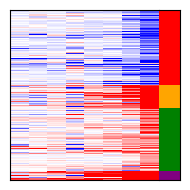

In [35]:
# Create the figure
fig = plt.figure(figsize=(2, 2))

# Create the outer GridSpec
outer = gridspec.GridSpec(1, 2, width_ratios=[7, 1], wspace=0.0)

# Create inner GridSpec for the first subplot (selected_df)
inner1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[0],width_ratios=[7], wspace=0)

# Create inner GridSpec for the second subplot (cluster_df)
inner2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[1], width_ratios=[1],wspace=0)

# Create the heatmap for selected_df
ax1 = fig.add_subplot(inner1[0])
sns.heatmap(selected_df, cmap=blue_white_red, 
            linewidths=0, linecolor='black', 
            vmin=-2, vmax=2, cbar=False, ax=ax1)
#ax1.set_xlabel('Dose')
ax1.set_xticks([])
ax1.set_xlabel('')
ax1.set_yticks([])
ax1.set_ylabel('')

for loc, spine in ax1.spines.items():
    if loc != 'right':
        spine.set_visible(True)
    else:
        spine.set_visible(False)

# Select specific columns for cluster_df
cluster_df = merged_df_sorted[['Cluster']]

# Create the heatmap for cluster_df
ax2 = fig.add_subplot(inner2[0])
sns.heatmap(cluster_df, cmap=custom_cmap, 
            linewidths=0, linecolor='black', 
            vmin=cluster_df.min().min(), vmax=cluster_df.max().max(), cbar=False, ax=ax2)
ax2.set_xlabel('')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_ylabel('')

for loc, spine in ax2.spines.items():
    if loc != 'left':
        spine.set_visible(True)
    else:
        spine.set_visible(False)

# Adjust layout
plt.tight_layout()

# Export the plot as a PDF
plt.savefig('Figures/RDDR_' + COI + '_mRNA_DEGs_Cluster_Heatmap.pdf')

# Show plot
plt.show()



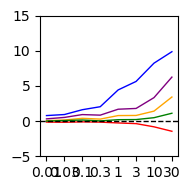

In [36]:
# Set the size of the figure and legend font size
plt.figure(figsize=(2, 2))

# Iterate over each cluster
for i, cluster in enumerate(cluster_means.index):
    # Get the mean values for the current cluster
    cluster_data = cluster_means.loc[cluster]
    
    # Plot a line graph for the current cluster with the custom color
    plt.plot(cluster_data.index.astype(str), cluster_data.values,
             label=f'Cluster {cluster}', color=custom_cmap(i), linewidth=1.0)
    
# Add labels and title
#plt.xlabel('Dose')
#plt.ylabel('Average Log2FC')
#plt.title('Average Values for Each Time Point by Cluster')
#plt.legend()
plt.grid(False)  # Remove gridlines
plt.yticks([-5,0,5,10,15])
plt.ylim(-5,15)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1.0)

# Adjust layout
plt.tight_layout()

# Export the plot as a PDF
plt.savefig('Figures/RDDR_' + COI + '_mRNA_DEGs_Cluster_Means_Lineplot.pdf')

# Show the plot
plt.show()
